In [ ]:
import glob
import pandas as pd
import pickle, os
from pathlib import Path
from collections import defaultdict
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

: 

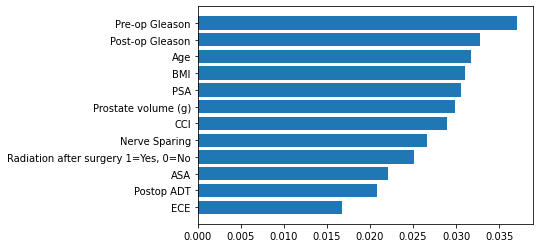

In [17]:

data_dir = Path("/home/jiashu/seq/raw_data")
processed_data_dir = Path("/home/jiashu/seq/processed/train30_test10")

df = pd.read_excel(
    data_dir / "Dissection Gesture_Clinical Data.xlsx", engine='openpyxl',
)

df['Nerve Sparing'] = df['Nerve Sparing'].apply(
    lambda val: 1 if val == 'full' else 0
)
y = df['ESI @ 12 mo']
X = df.drop(["Case ID", "Surgeon ID", "Pre-Op SHIM", 'ESI @ 12 mo'], axis=1)

feature_importances = np.zeros(len(X.columns), dtype=float)
for k in range(4):
    xgb = XGBClassifier()
    xgb.load_model(f"/home/jiashu/seq/selected_ckpt/xgboost/client-k{k}.json")
    feature_importances += xgb.feature_importances_

feature_names = X.columns
feature_importances = feature_importances / len(X.columns)
sorted_idxs = feature_importances.argsort()
plt.figure()
plt.barh(
    feature_names[sorted_idxs],
    feature_importances[sorted_idxs]
)
plt.savefig("/home/jiashu/seq/artifact/xgboost/avg.png",bbox_inches="tight",dpi=200)

In [18]:
X.columns

Index(['Age', 'BMI', 'CCI', 'PSA', 'Pre-op Gleason', 'ASA', 'Nerve Sparing',
       'Prostate volume (g)', 'Post-op Gleason', 'ECE',
       'Radiation after surgery 1=Yes, 0=No', 'Postop ADT'],
      dtype='object')

In [2]:
work_dir = "/home/jiashu/seq"
data_dir = "/home/jiashu/seq/raw_data"
data_dir = Path(data_dir)

meta = pd.read_excel(data_dir / "clinical data.xlsx")

/home/jiashu/.conda/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """


In [9]:
meta.groupby("ESI @ 12 mo").mean().sum(1)

ESI @ 12 mo
0    3.521739
1    3.388889
dtype: float64

In [13]:
meta[meta["ESI @ 12 mo"] == 1].sum(0)

Case ID                                            P-002P-005P-015P-047P-050P-061P-072P-088P-103P...
Nerve Sparing- Left (0=no, 1=partial, 2= full)                                                    29
Nerve Sparing- Right (0=no, 1=partial, 2= full)                                                   32
ESI @ 12 mo                                                                                       18
dtype: object

In [4]:
k_dir = "/home/jiashu/seq/processed"
d = {}
for k in range(5):
    with open(os.path.join(k_dir, f"k{k}", "test.pkl"), "rb") as f:
        seq = pickle.load(f)
    d[k] = seq

In [6]:
for k, seq in d.items():
    s = [
        data["L"]["Nerve Sparing"] + data["R"]["Nerve Sparing"]
        for case, data in seq.items()
    ]
    print(f"{k} -> {s}")

0 -> [4, 1, 4, 4, 3, 4, 3, 2]
1 -> [4, 4, 4, 2, 4, 4, 4, 1]
2 -> [4, 4, 4, 2, 4, 4, 4, 1]
3 -> [4, 4, 4, 2, 4, 4, 4, 1]
4 -> [4, 4, 4, 2, 4, 4, 4, 1]


In [19]:
with open("/home/jiashu/seq/processed_data/seq.pl", "rb") as f:
    seqs = pickle.load(f)

In [39]:
has_scores = []
for caseid, seq in seqs.items():
    if "scores" in seq:
        has_scores.append((caseid, seq["label"]))

In [41]:
pos_scores = np.array([
    np.array(list(seqs[caseid]["scores"].values()))
    for caseid,label in has_scores 
    if label == 1
])

neg_scores = np.array([
    np.array(list(seqs[caseid]["scores"].values()))
    for caseid,label in has_scores 
    if label == 0
])

In [44]:
pos_scores.mean(0), neg_scores.mean(0)

(array([2.96, 3.  , 2.92, 2.59, 2.76]),
 array([2.80454545, 3.        , 2.94090909, 2.82727273, 2.62727273]))

In [28]:
has_scores

[('P-321', 0),
 ('P-004', 0),
 ('P-008', 0),
 ('P-015', 1),
 ('P-030', 0),
 ('P-040', 0),
 ('P-047', 1),
 ('P-050', 1),
 ('P-002', 1),
 ('P-026', 0),
 ('P-007', 0),
 ('P-037', 0),
 ('P-042', 0),
 ('P-049', 0),
 ('P-005', 1),
 ('P-046', 0)]

In [23]:
caseid = 'P-321'
seq = seqs[caseid]

In [25]:
seq['scores']

{'ave_gs': 2.75, 'ave_iva': 3, 'ave_rtp': 3.0, 'ave_th': 3.0, 'ave_tr': 2.75}

In [24]:
seq.keys(), seq["L"].keys()

(dict_keys(['L', 'R', 'scores', 'label']),
 dict_keys(['Gesture', 'Arm', 'Note', 'Nerve Sparing']))

In [14]:
len(seq["L"]["Gesture"])

330

In [15]:
len(seq["R"]["Gesture"])

227

In [21]:
path = "/home/jiashu/seq/processed/train30_test10/k0"
out = "/home/jiashu/seq/artifact/gesture_analysis/case_gesture_freq"
with open(f"{path}/train_processed.pkl", "rb") as f:
    seq = pickle.load(f)

with open(f"{path}/valid_processed.pkl", "rb") as f:
    seq2 = pickle.load(f)
gesture_mapping = {}
with open(f"/home/jiashu/seq/processed/train30_test10/k0/gesture_mapping.txt") as f:
    for line in f:
        gesture, gid = line.rstrip().split("->")
        gesture_mapping[int(gid)] = gesture
seq = {
    **seq, **seq2
}

In [26]:
for case in seq:
    L, R = seq[case]["L"]['gesture'], seq[case]["R"]['gesture']
    L = [
            gesture_mapping[g]
            for i, g in enumerate(L)
        ]

    R = [
            gesture_mapping[g]
            for i, g in enumerate(R)
        ]
    from collections import Counter
    cL, cR = Counter(L), Counter(R)
    with open(f"{out}/{case}.txt", "w") as f:
        f.write("case id :: Left or Right \n")
        f.write("\tgesture\tcounts\n")
        for LR, counter in zip(["L", "R"], [cL, cR]):
            f.write(f"{case}::{LR}\n")
            for gesture, ct in counter.most_common():
                f.write(f"\t{gesture}\t{ct}\n")

In [25]:
cL.most_common()

[('c', 102),
 ('p', 96),
 ('r', 51),
 ('m', 47),
 ('s', 15),
 ('a', 7),
 ('g', 7),
 ('h', 6),
 ('t', 4),
 ('k', 3),
 ('other', 1),
 ('w', 1)]